In [2]:
import sys
import numpy
import pickle
import matplotlib.pyplot as plt, pandas as pd, matplotlib as mpl, random
def utkarshGrid(): plt.minorticks_on() ; plt.grid(color='grey',which='minor',linestyle=":",linewidth='0.1',) ; plt.grid(color='black',which='major',linestyle=":",linewidth='0.1',); return None
def utkarshGridAX(ax): ax.minorticks_on() ; ax.grid(color='grey',which='minor',linestyle=":",linewidth='0.1',) ; ax.grid(color='black',which='major',linestyle=":",linewidth='0.1',); return None
mpl.rcParams['legend.frameon'], mpl.rcParams['figure.autolayout'] = False, True,
colour = ["dodgerblue", "goldenrod", "crimson", "teal", "yellowgreen", "grey"]
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Palatino"],})
def utkarshWrapper(): plt.legend();plt.utkarshGrid() ;plt.gca().tick_params(direction='in', which='both', right=True, top=True); plt.tight_layout(); return None
def utkarshWrapperAX(ax): utkarshGridAX(ax); ax.tick_params(direction='in', which='both', right=True, top=True); return None; 
plt.utkarshGrid = utkarshGrid; plt.utkarshWrapper = utkarshWrapper
def colour_sample(n = 2, col = colour, seed = 7236): random.seed(seed) ; return random.sample(colour, n)
plt.rcParams["image.cmap"] = "Set2" # I recommend, Set2, Dark2
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colour) # Use your own OR plt.cm.Set2.colors

In [3]:
%reload_ext autoreload
%autoreload 2
from run_inference import *
from postprocessing_functions import *

/Users/utkarsh/GitHub/P_NS/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
mcmc = None
path = f"results/prior"
mcmc = pickle_read(path)
prior_samples = infer_samples(mcmc)

In [5]:
mcmc = None
path = f"results/posterior"
mcmc = pickle_read(path)
posterior_samples = infer_samples(mcmc)
mcmc.print_summary()


                         mean       std    median      5.0%     95.0%     n_eff     r_hat
               A[0]      0.03      0.57      0.04     -0.83      0.95   3663.87      1.00
         alpha_1[0]     -1.43      1.55     -1.26     -4.28      0.66   1523.85      1.00
         alpha_2[0]     -0.16      0.46     -0.17     -0.92      0.56   1550.90      1.00
          beta_1[0]      1.13      0.49      1.09      0.33      1.92   2861.86      1.00
          beta_2[0]      2.28      0.75      2.22      1.09      3.51   2660.43      1.00
        eta_high[0]     25.06     14.23     25.17      0.55     44.94   5645.39      1.00
         eta_low[0]     24.95     14.57     24.72      2.45     47.50   5315.09      1.00
         eta_max[0]      4.50      2.71      4.25      0.00      8.55   3169.20      1.00
         eta_min[0]     30.57     11.33     30.99     12.21     47.43   4658.30      1.00
      gamma_high[0]      6.00      1.19      5.99      4.26      7.88   3962.23      1.00
       ga

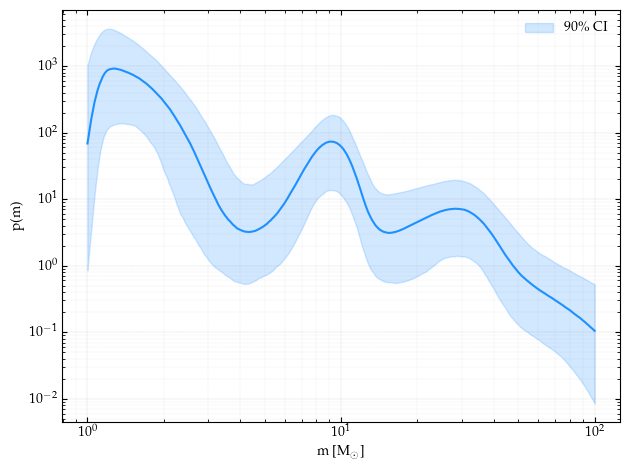

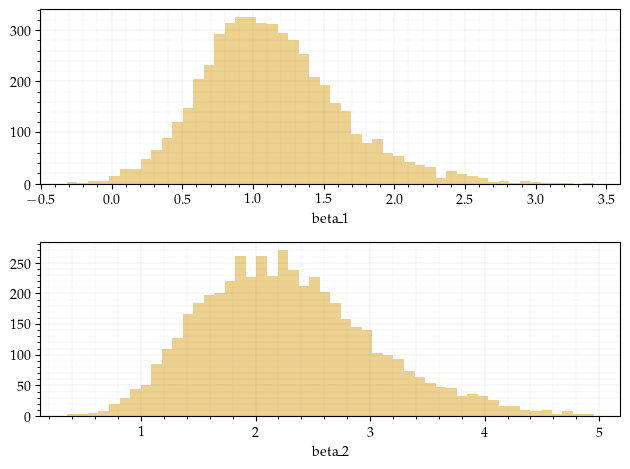

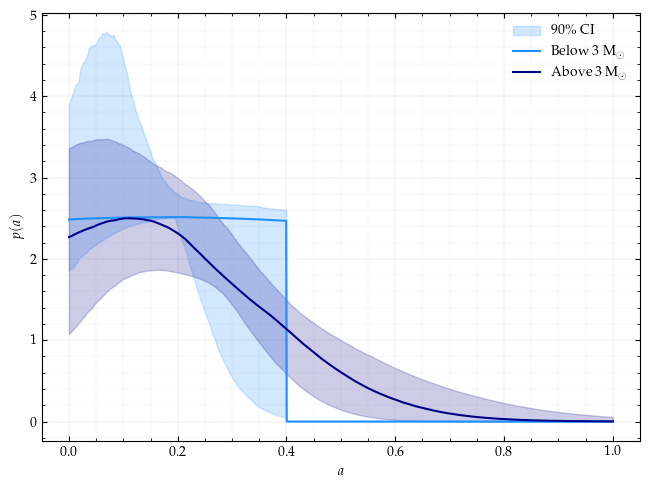

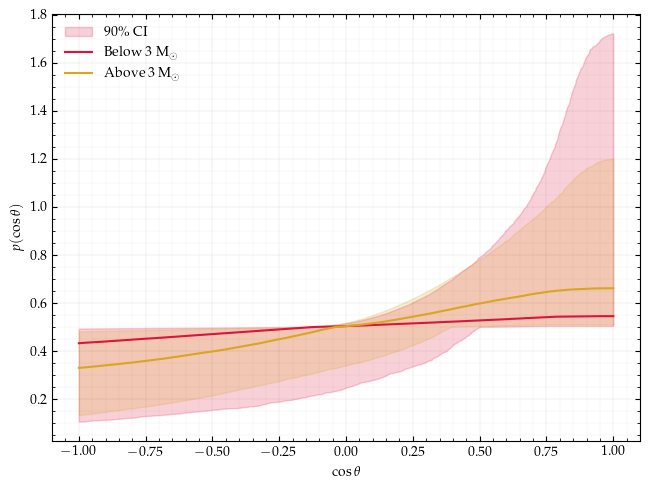

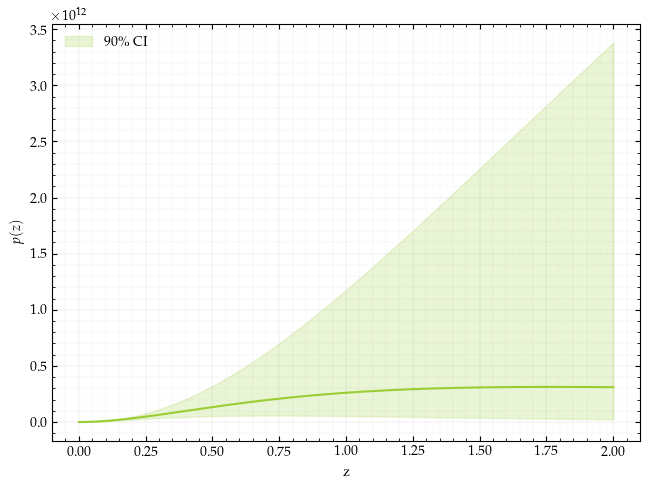

In [6]:
from config.mass1d_func import pdb_with_NG
from config.spin_func import prob_chi, prob_costilt
from config.distance_func import powerlaw_redshift

plot_p_m(posterior_samples, function=pdb_with_NG)
plot_p_pairing(posterior_samples)
plot_p_chi(posterior_samples, function=prob_chi)
plot_p_costilt(posterior_samples, function=prob_costilt)
plot_p_z(posterior_samples, function=powerlaw_redshift)
plt.show()

In [7]:
import os
import arviz as az

if os.path.exists("results/trace1.png") or os.path.exists("results/trace2.png") or os.path.exists("results/trace.png"):
    print("Trace plots already exist, skipping generation")
else:
    print("Generating trace plots")
    data = az.from_numpyro(mcmc)
    var_names_lst = get_non_deterministic_params(mcmc)

    if len(var_names_lst) >= 20:
        cut1 = var_names_lst[:20]
        cut2 = var_names_lst[20:]

        assert len(cut1) + len(cut2) == len(var_names_lst)

        az.plot_trace(data, var_names=cut1, compact=True)
        plt.savefig("results/trace1.png")
        az.plot_trace(data, var_names=cut2, compact=True)
        plt.savefig("results/trace2.png")
    else:
        az.plot_trace(data, var_names=var_names_lst, compact=True)
        plt.savefig("results/trace.png")

Trace plots already exist, skipping generation


/Users/utkarsh/GitHub/P_NS/sampler/runs/pdbNG_betaSplit_brokenG_1_full/postprocessing_functions.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  def utkarshWrapper(): plt.legend();plt.utkarshGrid();plt.gca().tick_params(direction='in', which='both', right=True,


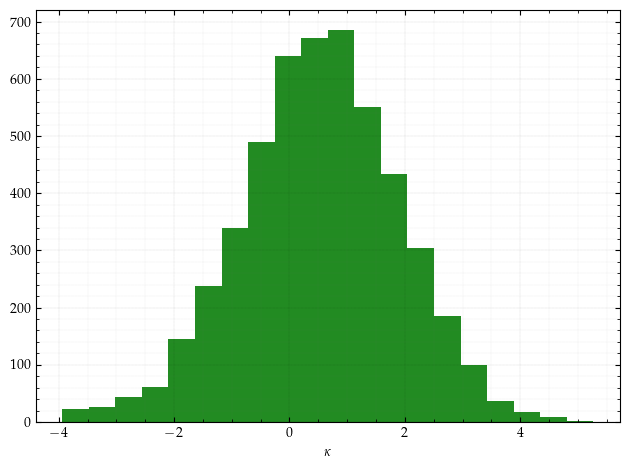

In [8]:
plt.hist(posterior_samples["kappa"], bins = 20, color = "forestgreen")
plt.xlabel(r"$\kappa$")
plt.utkarshWrapper()
plt.savefig("results/kappa_hist.png")

In [9]:
from model_vector import model_vector

import os

# try:
#     os.remove("results/postprocessed_samples")
# except: pass

if os.path.exists("results/postprocessed_samples"):
    with open("results/postprocessed_samples", "rb") as f:
        postprocessed_posterior_samples = pickle.load(f)
else:
    postprocessed_posterior_samples = add_postprocessing_effects(posterior_samples, model_vector)
    with open("results/postprocessed_samples", "wb") as f:
        pickle.dump(postprocessed_posterior_samples, f)

config = configparser.ConfigParser()
config.read('config/config.ini')
event_folder_name = config["DIRECTORIES"]["event_folder_name"]
event_file_name = config["DIRECTORIES"]["event_file_name"]
translate_dir = "../../"
events = numpy.loadtxt(translate_dir+event_folder_name+event_file_name, dtype=str)

for event_i in tqdm(range(len(postprocessed_posterior_samples["neff_events"].T))):
    neff = postprocessed_posterior_samples["neff_events"].T[event_i]
    filename = events[event_i][:14]
    plot_neff(neff, filename)
    plt.close()

100%|██████████| 66/66 [00:15<00:00,  4.18it/s]


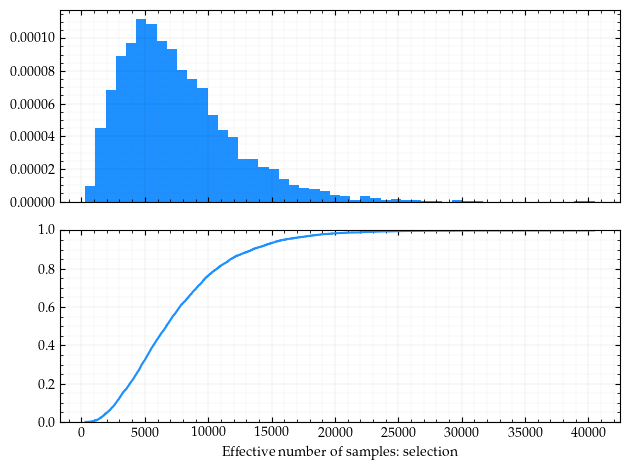

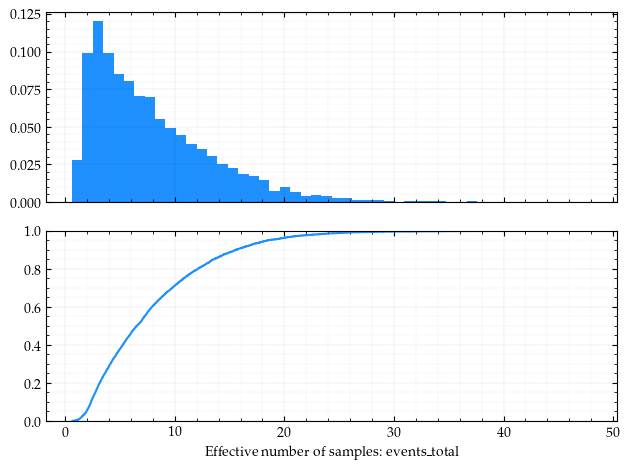

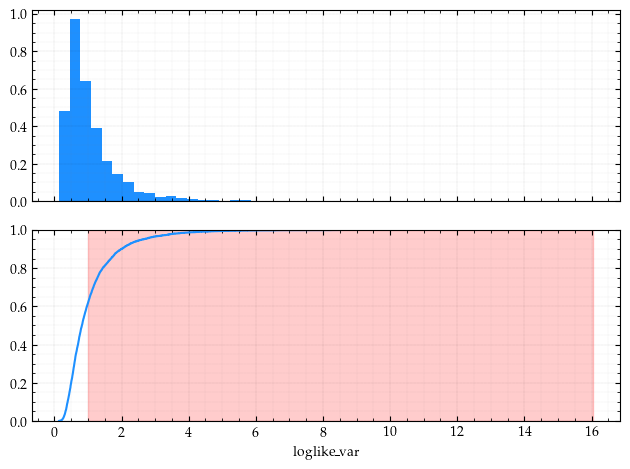

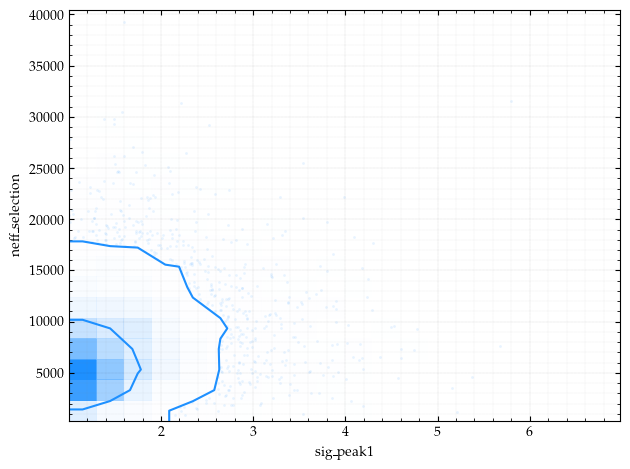

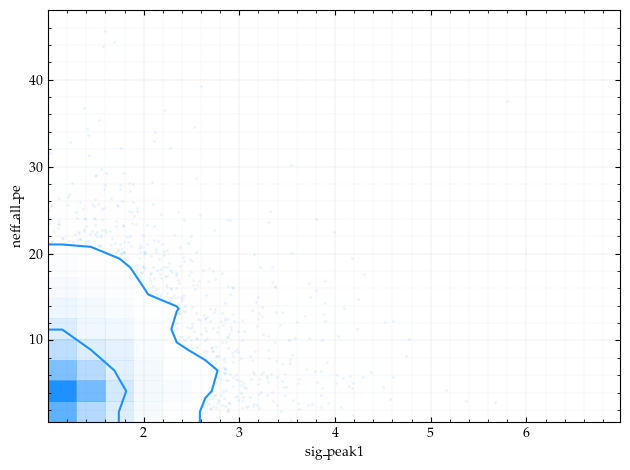

In [10]:
plot_neff(postprocessed_posterior_samples["neff_selection"], "selection")
plot_neff(postprocessed_posterior_samples["neff_events_total"], "events_total")
plot_neff(postprocessed_posterior_samples["loglike_var"], "loglike_var")
plt.xlabel("loglike_var")
plt.axvspan(1, max(postprocessed_posterior_samples["loglike_var"]), color = "red", label = "Var samples greater than 1", alpha = 0.2)
plt.savefig("results/loglike_var.png")

plt.figure()
plot_corner(postprocessed_posterior_samples["sig_peak1"], postprocessed_posterior_samples["neff_selection"], "sig_peak1", "neff_selection")
plt.figure()
plot_corner(postprocessed_posterior_samples["sig_peak1"], postprocessed_posterior_samples["neff_events_total"], "sig_peak1", "neff_all_pe")

In [11]:
params = get_non_deterministic_params(mcmc) + ["neff_events_total", "neff_selection"]
params_samples = np.array([postprocessed_posterior_samples.get(key).flatten() for key in params]).T
corner.corner(params_samples, labels=params, color="dodgerblue")
plt.savefig("results/corner_postprocessed.png")
plt.close()

In [12]:
data, data_arg = curate_data()
theta_pe, importance_pe, theta_CG, importance_CG, theta_inj, importance_inj, len_NCG, len_CG, len_inj, N_CG = data_arg
lambda_pop = posterior_samples_to_complete_numpy(posterior_samples)

Not in COURSE GRAIN: 66


100%|██████████| 66/66 [00:05<00:00, 11.23it/s]


In COURSE GRAIN: 0


In [206]:
# Attempting to do a posterior predictive check
from model_vector import model_vector
import numpy as np

# expected number of detections
N_det = 1000

# set numpy key
# np.random.seed(0)

observed_draw_lst = []
predicted_draw_lst = []
# len_lambda = int(len(lambda_pop.T)/10)
len_lambda = 1

for i in tqdm(range(len_lambda)):
    # for a single lambda
    # generate a random integer between 0 and size of lambda_pop
    rand_int = np.random.randint(0, lambda_pop.shape[0])
    random_lambda = lambda_pop.T[rand_int]

    # generate predicted draw from injections
    num = model_vector(theta_inj, random_lambda)
    dem = importance_inj
    inj_weights = np.exp(num - importance_inj)
    inj_weights /= np.sum(inj_weights)
    # draw one sample of theta_inj given weights
    rand_choices = np.random.choice(len(inj_weights), size = N_det, p = inj_weights)
    predicted_draw = np.array(theta_inj).T[rand_choices]


    # generate observed draw from PE
    num = model_vector(theta_pe, random_lambda)
    dem = importance_pe
    pe_weights = np.exp(num - importance_pe)
    pe_weights_norm = pe_weights / np.sum(pe_weights)
    weights_flat = pe_weights_norm.flatten()

    # Change pe_flatten to same shape as weights_flat (7, 264000)
    pe_flatten = np.array(theta_pe).reshape(7, len(weights_flat))

    # draw N_det samples from theta_pe given weights
    random_choice = np.random.choice(pe_flatten.shape[1], size=N_det, p=weights_flat)
    observed_draw = pe_flatten.T[random_choice]

    observed_draw_lst.append(observed_draw)
    predicted_draw_lst.append(predicted_draw)

observed_draw_arr = np.array(observed_draw_lst)
predicted_draw_arr = np.array(predicted_draw_lst)
print(observed_draw_arr.shape)
print(predicted_draw_arr.shape)

100%|██████████| 1/1 [00:00<00:00, 10.37it/s]

(1, 1000, 7)
(1, 1000, 7)


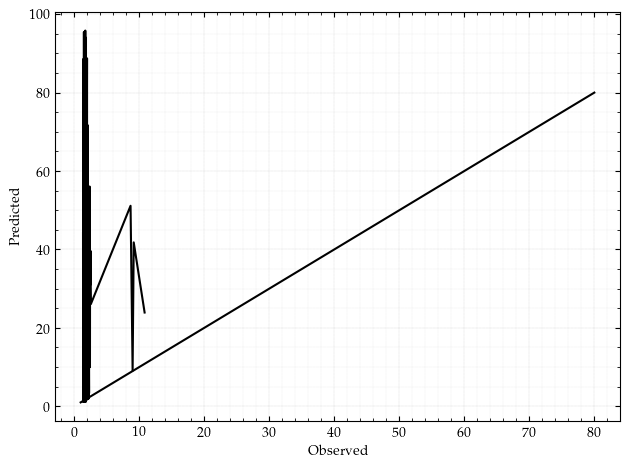

In [207]:
# mass1_source, mass2_source, z, a1, costilt1, a2, costilt2 = theta
mass1_idx = 0; mass2_idx = 1 ; redshift_idx = 2; a1_idx = 3; costilt1_idx = 4; a2_idx = 5; costilt2_idx = 6

theta_idx = mass1_idx


for lamda_idx in range(observed_draw_arr.shape[0]):
    X = observed_draw_arr[lamda_idx, :, theta_idx]
    Y = predicted_draw_arr[lamda_idx, :, theta_idx]
    idx = np.argsort(X)
    X = X[idx]
    Y = Y[idx]
    plt.plot(X, Y, color = "black", alpha = 1)
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.utkarshWrapper()
plt.plot([1, 80], [1, 80], color = "black", label = "y = x")